# Allocate Benchmarks

In [44]:
# select measurement file
file_name = "../output/2024-11-07 18-25-43 full.json"

# select style options
grey_fill_between = False

enable_storage_reference = False

if grey_fill_between:
    fill_between_args = {"color": "grey"}
else:
    fill_between_args = {}


In [45]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [46]:
from util.convert import convert_data
from IPython.core.display import HTML

# filter and convert data
allocate_min = convert_data(raw_data, "allocate_min", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_max = convert_data(raw_data, "allocate_max", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_case1 = convert_data(raw_data, "allocate_case_1", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])

display(HTML("<b>MIN Data:</b>"))
display(allocate_min.head())
display(HTML("<b>MAX Data:</b>"))
display(allocate_max.head())
display(HTML("<b>Case 1 Data:</b>"))
display(allocate_case1.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,833.798,833,834,0,esp32c3,100,1000,16000
1,854.797,854,855,32,esp32c3,100,1000,16000
2,858.000,858,858,64,esp32c3,100,1000,16000
3,861.401,861,862,96,esp32c3,100,1000,16000
4,864.798,864,865,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,37580.601,37580,37581,0,esp32c3,100,1000,16000
1,28025.842,28025,28067,32,esp32c3,100,1000,16000
2,24983.599,24983,24984,64,esp32c3,100,1000,16000
3,25452.500,25439,25466,96,esp32c3,100,1000,16000
4,25692.000,25692,25692,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,34153.250,34153,34154,0,esp32c3,100,1000,16000
1,24178.396,24178,24241,32,esp32c3,100,1000,16000
2,20849.402,20849,20850,64,esp32c3,100,1000,16000
3,17520.752,17520,17522,96,esp32c3,100,1000,16000
4,17524.251,17524,17525,128,esp32c3,100,1000,16000


In [47]:
from util.convert import scale_data

for (dataset, name) in [(allocate_min, "MIN"), (allocate_max, "MAX"), (allocate_case1, "CASE 1")]:
    scaled_data = scale_data(dataset, "us")
    display(HTML(f"<b>{name}:</b>"))
    display(scaled_data["mean"].agg(["min", "max"]))

min    52.112375
max    59.937312
Name: mean, dtype: float64

min    1185.312688
max    2348.787563
Name: mean, dtype: float64

min     473.434125
max    2134.578125
Name: mean, dtype: float64

In [48]:
from util.convert import get_storage_measurement
from IPython.core.display import HTML

(storage_read, storage_write) = get_storage_measurement(raw_data, allocate_max["options.object_size"].max())

display(HTML("<b>READ Data:</b>"))
display(storage_read.head())
display(HTML("<b>WRITE Data:</b>"))
display(storage_write.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,610.399,610,611,0,esp32c3,100,1000,16000
1,1074.200,1074,1075,32,esp32c3,100,1000,16000
2,1405.006,1404,1406,64,esp32c3,100,1000,16000
3,1869.197,1869,1870,96,esp32c3,100,1000,16000
4,2200.401,2200,2201,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,1128.000,1128,1128,0,esp32c3,100,1000,16000
1,1511.583,1511,1512,32,esp32c3,100,1000,16000
2,1765.796,1765,1766,64,esp32c3,100,1000,16000
3,2150.403,2150,2151,96,esp32c3,100,1000,16000
4,2404.564,2404,2405,128,esp32c3,100,1000,16000


# Final Plot

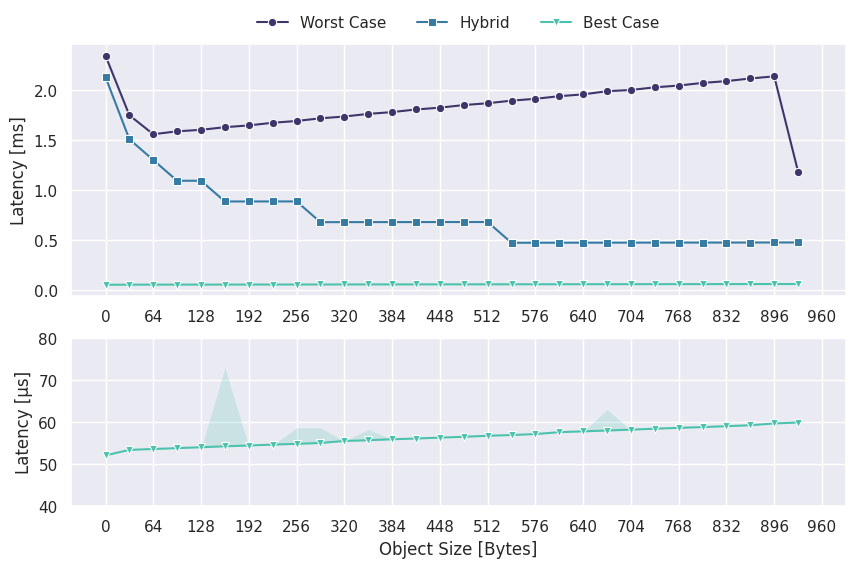

In [49]:
from util.plot import set_grid, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

set_theme()
fig = plt.figure(1)
fig.set_figheight(6)
fig.set_figwidth(10)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.5, 1]) 
ax = plt.subplot(gs[0])

unit = "ms"

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel(None)
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
#ax.set_ylim(bottom=-4, top=60)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    ax.legend(handles, labels, loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)
else:
    ax.legend(loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)


set_theme(3, 2)
ax = plt.subplot(gs[1])

unit = "µs"

# if len(allocate_max) != 0:
#     allocate_max_scaled = scale_data(allocate_max, unit)
#     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
#     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

#if len(allocate_case1) != 0:
#    allocate_case1_scaled = scale_data(allocate_case1, unit)
#    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
#    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=40, top=80)
ax.get_legend().remove()

save_plot("allocate", save_asset=True)

# Same Plot in Presentation Style

In [50]:
from util.plot import set_grid, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
2024-11-07 18-25-43 full.json
set_theme()
sns.set_context(context="talk")
fig = plt.figure(1)
fig.set_figheight(3)
fig.set_figwidth(12.5)

gs = gridspec.GridSpec(nrows=1, ncols=1) 
ax = plt.subplot(gs[0])

unit = "ms"

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    ax.legend(handles, labels, loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)
else:
    ax.legend(loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]", labelpad=25)
#plt.axis([200, 300, 10000, 15000])

plt.savefig(f"../figures/allocate_presentation_1.pdf", bbox_inches='tight', facecolor='#fafafa')


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (356878219.py, line 6)

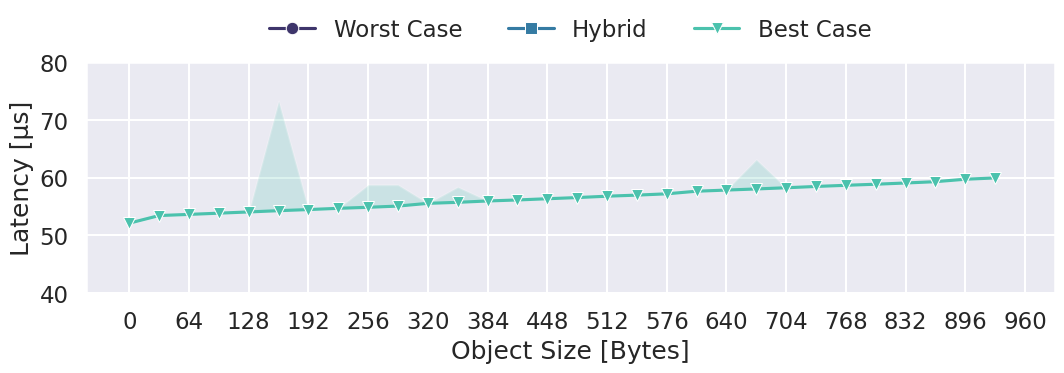

In [43]:
from util.plot import set_grid, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(1)
fig.set_figheight(3)
fig.set_figwidth(12.5)

gs = gridspec.GridSpec(nrows=1, ncols=1) 

set_theme()
sns.set_context(context="talk")
ax = plt.subplot(gs[0])

unit = "µs"

if len(allocate_max) != 0:
     allocate_max_scaled = scale_data(allocate_max, unit)
     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    ax.legend(handles, labels, loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)
else:
    ax.legend(loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)


set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=40, top=80)

plt.savefig(f"../figures/allocate_presentation_2.pdf", bbox_inches='tight', facecolor='#fafafa')
